In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
from astropy.stats import LombScargle
import math
import pylab
import scipy.ndimage
from scipy.fftpack import fft,ifft,fftfreq
import pickle

In [2]:
pickleload = open("filtered_and_mixed.pickle","rb")
data = pickle.load(pickleload)

In [3]:
def mix(data):
    mixer = data["amp0"] * np.exp(1j * (2 * np.pi * data["f0"] * data["time"] - data["phase0"]))
    mf = mixer * data["flux"]
    remf=mf.real
    immf=mf.imag
    sremf = scipy.ndimage.filters.gaussian_filter1d(remf, 50)
    simmf = scipy.ndimage.filters.gaussian_filter1d(immf, 50)
    return remf,immf,sremf,simmf
remf, immf, sremf, simmf = mix(data)

In [4]:
def objective(f,amp,phase,data):
    mixer = amp * np.exp(1j * (2 * np.pi * f * data["time"] - phase)) # MUST MATCH mix()
    mf = mixer * data["flux"]
    return np.var(mf.imag)

Optimize!

In [11]:
for i in range(4): # magic number of iterations!
    print("iteration", i)
    remf, immf, sremf, simmf = mix(data)
    newA = data["amp0"] / np.sqrt(np.mean(sremf*sremf + simmf*simmf))
    print("amps:", data["amp0"], newA)
    data["amp0"] = newA
    remf, immf, sremf, simmf = mix(data)
    newphase = data["phase0"] + np.arctan2(np.mean(simmf), np.mean(sremf))
    print("phases:", data["phase0"], newphase)
    data["phase0"] = newphase
    remf, immf, sremf, simmf = mix(data)
    A = data["amp0"]
    phi = data["phase0"]
    output=minimize(objective,data["f0"],args=(A,phi,data),method="Nelder-Mead")
    print("frequencies:", data["f0"], output.x[0])
    data["f0"] = output.x[0]

iteration 0
amps: 1183.5045254881045 1183.5045254881045
phases: -1.1333946419681884 -1.1333946419743925
frequencies: 14.187639706075974 14.187639706075974
iteration 1
amps: 1183.5045254881045 1183.5045254881045
phases: -1.1333946419743925 -1.1333946419706196
frequencies: 14.187639706075974 14.187639706075974
iteration 2
amps: 1183.5045254881045 1183.5045254881047
phases: -1.1333946419706196 -1.1333946419692578
frequencies: 14.187639706075974 14.187639706075974
iteration 3
amps: 1183.5045254881047 1183.5045254881047
phases: -1.1333946419692578 -1.1333946419679557
frequencies: 14.187639706075974 14.187639706075974


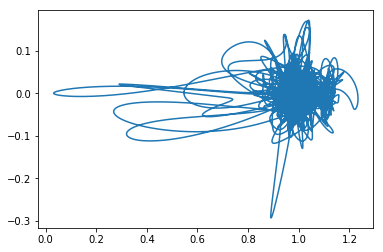

In [12]:
plt.plot(sremf, simmf)

In [7]:
q,y= LombScargle(data["time"], simmf).autopower()

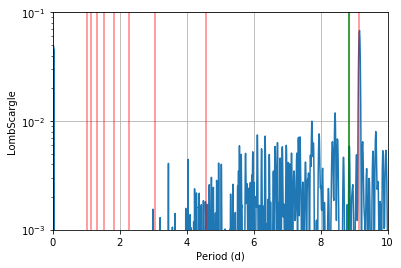

In [8]:
plt.plot(1./q,y)
plt.xlabel("Period (d)")
plt.ylabel("LombScargle")
plt.xlim(0., 10.)
plt.ylim(1e-3, 1e-1)
plt.semilogy()
plt.grid()
for factor in range(1,10):
    plt.axvline(9.16 / factor, color="r", alpha=0.5)
plt.axvline(8.85,color='g')

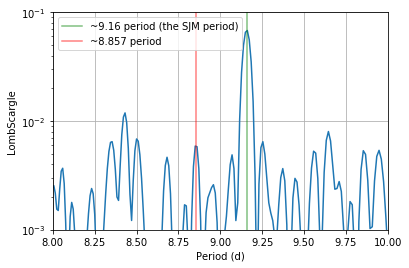

In [9]:
plt.plot(1./q,y)
plt.xlabel("Period (d)")
plt.ylabel("LombScargle")
plt.xlim(8,10)
plt.ylim(1e-3, 1e-1)
plt.semilogy()
plt.grid()
plt.axvline(9.161,c='g',alpha=.5,label="~9.16 period (the SJM period)")
plt.axvline(8.857,c='r',alpha=.5,label="~8.857 period")
plt.legend()

In [10]:
dictionary3={"sremf":sremf,
             "simmf":simmf}

picklesave = open("realimag.pickle","wb")
pickle.dump(dictionary3, picklesave)
picklesave.close()